# MNIST Digit Classification Using RNNs

The task at hand involves creating a Recurrent Neural Network (RNN) to perform classification on the MNIST digit dataset. This dataset encompasses various handwritten digits, and the ultimate objective is to construct a specialized model capable of accurately recognizing these handwritten digits, essentially resulting in a proficient handwritten digit recognition system.

# 1. MNIST Classification Using RNN

# Importing the required Libraries

In [61]:
import numpy as np
import torch
import matplotlib.pylab as plt
import math
import random

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.transforms.functional import invert, rgb_to_grayscale
from torch.utils.data import random_split, Subset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.optim as optim
from torchsummary import summary

from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time

from PIL import Image
import cv2

# Loading the dataset

In [62]:
complete_train_data = dsets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)

train_data, val_data = random_split(complete_train_data, [50000, 10000])
test_data = dsets.MNIST(root = './data', train = False, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)

# Creating batches

In [63]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

In [64]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100

# Creating the Models

In [65]:
#Vanilla RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Detach to prevent exploding/vanishing gradients
        out, hidden = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

pass

vanilla_rnn_net = VanillaRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vanilla_rnn_net.parameters(), lr = 0.001)

In [66]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
        pass
pass

lstm_net = LSTM(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr = 0.01)

In [67]:
# Bidirectional Model
class BiDirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiDirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        pass

    def forward(self, x):
        # Set initial hidden and cell states
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
        pass
pass

bidirectional_net = BiDirectionalRNN(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bidirectional_net.parameters(), lr = 0.001)

# Training the RNN Model

In [68]:
# Train the model
total_step = len(train_loader)

iter_list=[]
loss_list = []
pred_acc = []
val_acc = []
val_iter_list=[]
val_loss_list = []
epoch_list = []
iter = 0
val_iter = 0
running_loss = 0

for epoch in range(10):
    print("Epoch = ",epoch+1)
    epoch_list.append(epoch+1)
    # val loss
    val_running_loss = 0
    with torch.no_grad():
        for val_data in (val_loader):
            val_iter+=1
            val_image, val_label = val_data
            val_image = val_image.reshape(-1, sequence_length, input_size)
            val_output = vanilla_rnn_net(val_image)
            val_loss = criterion(val_output, val_label.squeeze().float())
            val_running_loss += val_loss.item()

            if (val_iter%10 == 0):
                val_iter_list.append(val_iter)
                val_loss_list.append(val_running_loss/100)
                val_running_loss = 0.0

    for data in (train_loader):
        iter +=1

        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels

        # Forward pass
        outputs = vanilla_rnn_net(images)
        loss = criterion(outputs, labels.float().squeeze())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (iter % 100) == 0:
            iter_list.append(iter)
            print("Iteration = ",iter)
            loss_list.append((running_loss/100))
            print("Loss = ",(running_loss/100))
            running_loss = 0.0

            pass

    #prediction accuracy
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = vanilla_rnn_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    pred_acc.append(100 * (correct / total))

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = vanilla_rnn_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    val_acc.append(100 * (correct / total))
    pass


pass

Epoch =  1
Iteration =  100
Loss =  2.305462725162506
Iteration =  200
Loss =  2.3056018590927123
Iteration =  300
Loss =  2.3060031604766844
Iteration =  400
Loss =  2.305486648082733
Iteration =  500
Loss =  2.3053637599945067
Epoch =  2
Iteration =  600
Loss =  2.3049837946891785
Iteration =  700
Loss =  2.305791018009186
Iteration =  800
Loss =  2.3054424262046815
Iteration =  900
Loss =  2.305871047973633
Iteration =  1000
Loss =  2.305829849243164
Epoch =  3
Iteration =  1100
Loss =  2.305049550533295
Iteration =  1200
Loss =  2.3065574240684508
Iteration =  1300
Loss =  2.3045572018623353
Iteration =  1400
Loss =  2.3064517831802367
Iteration =  1500
Loss =  2.305302178859711
Epoch =  4
Iteration =  1600
Loss =  2.3048524022102357
Iteration =  1700
Loss =  2.307177014350891
Iteration =  1800
Loss =  2.305144920349121
Iteration =  1900
Loss =  2.305270957946777
Iteration =  2000
Loss =  2.305472848415375
Epoch =  5
Iteration =  2100
Loss =  2.3065366697311402
Iteration =  2200
Lo

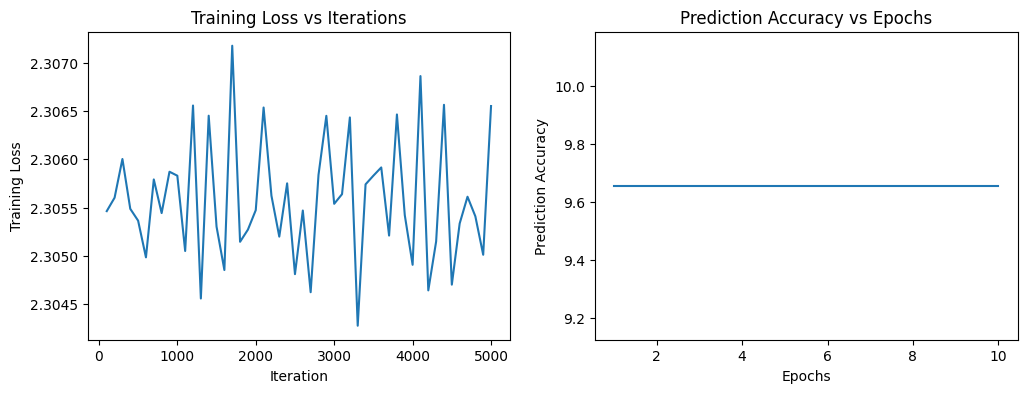

Accuracy of the network on the 50000 test images: 9.656 %


In [69]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(iter_list, loss_list)
axs[0].set_title('Training Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Training Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, pred_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = vanilla_rnn_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 50000 test images: {100 * (correct / total)} %')

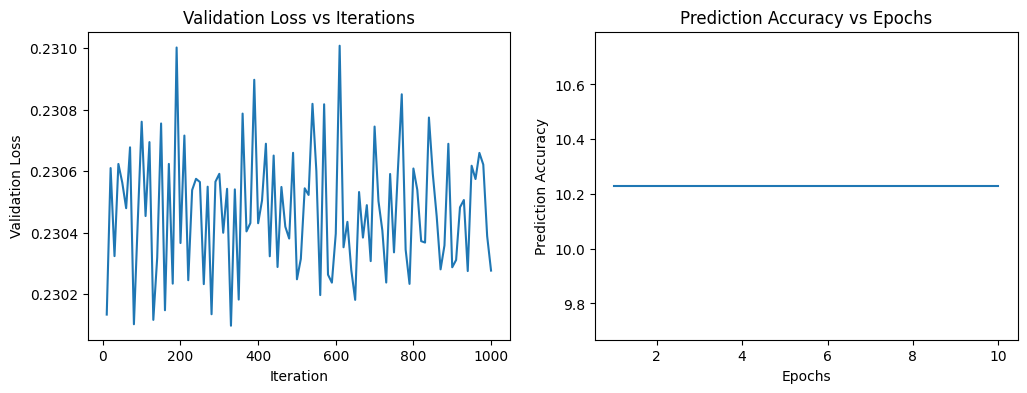

Accuracy of the network on the 10000 test images: 10.23 %


In [70]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(val_iter_list, val_loss_list)
axs[0].set_title('Validation Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Validation Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, val_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = vanilla_rnn_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

In [71]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = vanilla_rnn_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

Accuracy of the network on the 10000 test images: 9.74 %


# Training the LSTM Model

In [72]:
# Train the model
total_step = len(train_loader)

iter_list=[]
loss_list = []
pred_acc = []
val_acc = []
val_iter_list=[]
val_loss_list = []
epoch_list = []
iter = 0
val_iter = 0
running_loss = 0

for epoch in range(10):
    print("Epoch = ",epoch+1)
    epoch_list.append(epoch+1)
    # val loss
    val_running_loss = 0
    with torch.no_grad():
        for val_data in (val_loader):
            val_iter+=1
            val_image, val_label = val_data
            val_image = val_image.reshape(-1, sequence_length, input_size)
            val_output = lstm_net(val_image)
            val_loss = criterion(val_output, val_label.squeeze().float())
            val_running_loss += val_loss.item()
            if (val_iter%10 == 0):
                val_iter_list.append(val_iter)
                val_loss_list.append(val_running_loss/100)
                val_running_loss = 0.0

    for data in (train_loader):
        iter +=1

        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels

        # Forward pass
        outputs = lstm_net(images)
        loss = criterion(outputs, labels.float().squeeze())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (iter % 100) == 0:
            iter_list.append(iter)
            print("Iteration = ",iter)
            loss_list.append((running_loss/100))
            print("Loss = ",(running_loss/100))
            running_loss = 0.0

            pass

    #prediction accuracy
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = lstm_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    pred_acc.append(100 * (correct / total))

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = lstm_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    val_acc.append(100 * (correct / total))

    pass
pass

Epoch =  1
Iteration =  100
Loss =  2.30390216588974
Iteration =  200
Loss =  2.3044596195220945
Iteration =  300
Loss =  2.3041544914245606
Iteration =  400
Loss =  2.303885223865509
Iteration =  500
Loss =  2.304236600399017
Epoch =  2
Iteration =  600
Loss =  2.303907241821289
Iteration =  700
Loss =  2.30393269777298
Iteration =  800
Loss =  2.303961844444275
Iteration =  900
Loss =  2.304142851829529
Iteration =  1000
Loss =  2.3046934819221496
Epoch =  3
Iteration =  1100
Loss =  2.303895261287689
Iteration =  1200
Loss =  2.303836705684662
Iteration =  1300
Loss =  2.3047543501853944
Iteration =  1400
Loss =  2.3047244334220887
Iteration =  1500
Loss =  2.3034273767471314
Epoch =  4
Iteration =  1600
Loss =  2.3044283390045166
Iteration =  1700
Loss =  2.304320170879364
Iteration =  1800
Loss =  2.303765926361084
Iteration =  1900
Loss =  2.3039536619186403
Iteration =  2000
Loss =  2.304170002937317
Epoch =  5
Iteration =  2100
Loss =  2.304635429382324
Iteration =  2200
Loss =

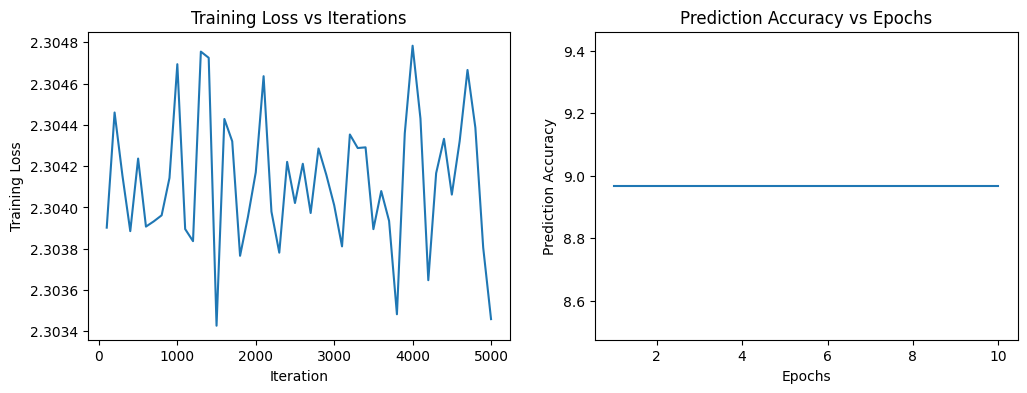

Accuracy of the network on the 50000 test images: 8.968 %


In [73]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(iter_list, loss_list)
axs[0].set_title('Training Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Training Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, pred_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = lstm_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 50000 test images: {100 * (correct / total)} %')

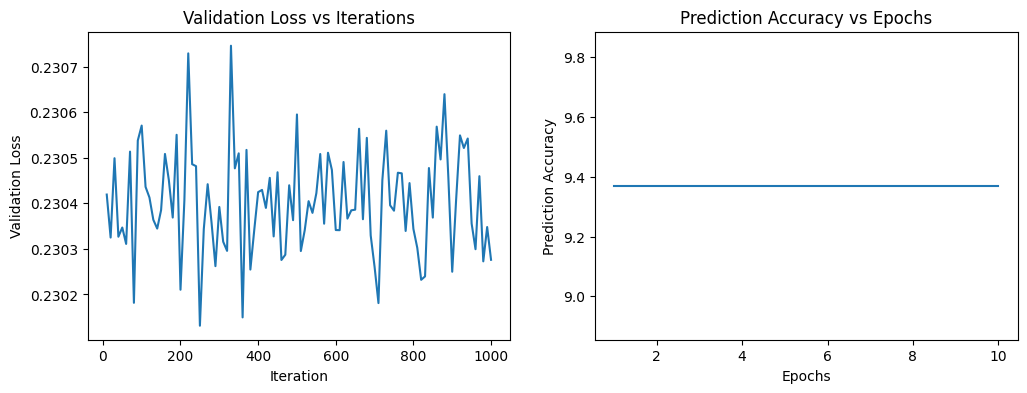

Accuracy of the network on the 10000 test images: 9.370000000000001 %


In [74]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(val_iter_list, val_loss_list)
axs[0].set_title('Validation Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Validation Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, val_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = lstm_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

In [75]:
correct = 0
total = 0
c = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = lstm_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

Accuracy of the network on the 10000 test images: 8.92 %


# Training the Bidirectional LSTM

In [76]:
# Train the model
total_step = len(train_loader)

iter_list=[]
loss_list = []
pred_acc = []
val_acc = []
val_iter_list=[]
val_loss_list = []
epoch_list = []
iter = 0
val_iter = 0
running_loss = 0

for epoch in range(10):
    print("Epoch = ",epoch+1)
    epoch_list.append(epoch+1)
    # val loss
    val_running_loss = 0
    with torch.no_grad():
        for val_data in (val_loader):
            val_iter+=1
            val_image, val_label = val_data
            val_image = val_image.reshape(-1, sequence_length, input_size)
            val_output = bidirectional_net(val_image)
            val_loss = criterion(val_output, val_label.squeeze().float())
            val_running_loss += val_loss.item()
            if (val_iter%10 == 0):
                val_iter_list.append(val_iter)
                val_loss_list.append(val_running_loss/100)
                val_running_loss = 0.0

    for data in (train_loader):
        iter +=1

        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)
        labels = labels

        # Forward pass
        outputs = bidirectional_net(images)
        loss = criterion(outputs, labels.float().squeeze())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (iter % 100) == 0:
            iter_list.append(iter)
            print("Iteration = ",iter)
            loss_list.append((running_loss/100))
            print("Loss = ",(running_loss/100))
            running_loss = 0.0

            pass

    #prediction accuracy
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = bidirectional_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    pred_acc.append(100 * (correct / total))

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.reshape(-1, sequence_length, input_size)

            # calculate outputs by running images through the network
            outputs = bidirectional_net(images)

            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs, dim=1, keepdim=True)
            actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    val_acc.append(100 * (correct / total))

    pass
pass

Epoch =  1
Iteration =  100
Loss =  1.4276567673683167
Iteration =  200
Loss =  0.5675029873847961
Iteration =  300
Loss =  0.3881430448591709
Iteration =  400
Loss =  0.30203222706913946
Iteration =  500
Loss =  0.22439659744501114
Epoch =  2
Iteration =  600
Loss =  0.1850602089613676
Iteration =  700
Loss =  0.17555106546729804
Iteration =  800
Loss =  0.16118990544229747
Iteration =  900
Loss =  0.14821168884634972
Iteration =  1000
Loss =  0.12898880157619716
Epoch =  3
Iteration =  1100
Loss =  0.10592592440545559
Iteration =  1200
Loss =  0.10990826193243265
Iteration =  1300
Loss =  0.10857565611600876
Iteration =  1400
Loss =  0.10126314034685492
Iteration =  1500
Loss =  0.102241199221462
Epoch =  4
Iteration =  1600
Loss =  0.08108589050360024
Iteration =  1700
Loss =  0.08682524114847183
Iteration =  1800
Loss =  0.08179602690972387
Iteration =  1900
Loss =  0.07690693356096745
Iteration =  2000
Loss =  0.07740317021496594
Epoch =  5
Iteration =  2100
Loss =  0.069447897290

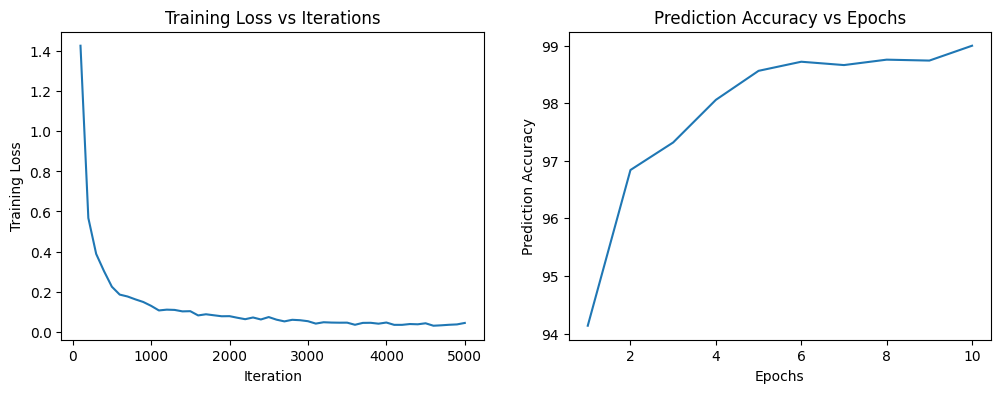

Accuracy of the network on the 50000 test images: 98.99799999999999 %


In [77]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(iter_list, loss_list)
axs[0].set_title('Training Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Training Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, pred_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = bidirectional_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 50000 test images: {100 * (correct / total)} %')

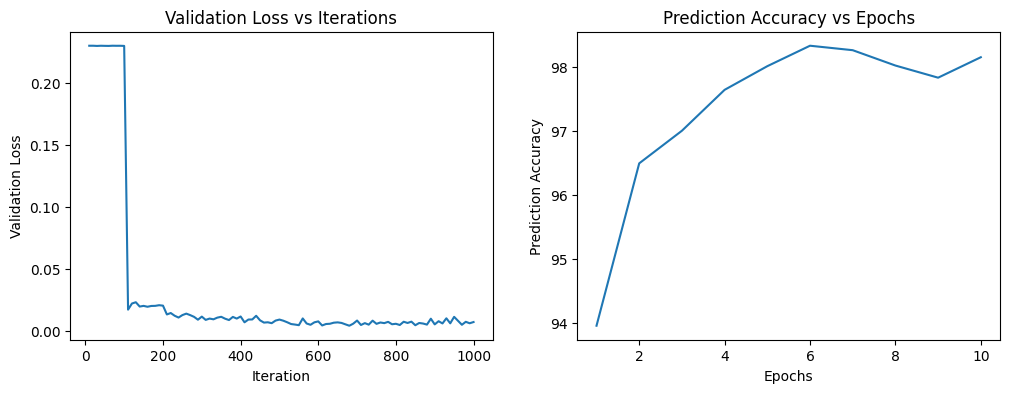

Accuracy of the network on the 10000 test images: 98.15 %


In [78]:
#plotting the training loss vs iterations
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first data in the first subplot
axs[0].plot(val_iter_list, val_loss_list)
axs[0].set_title('Validation Loss vs Iterations')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Validation Loss')

# Plot the second data in the second subplot
axs[1].plot(epoch_list, val_acc)
axs[1].set_title('Prediction Accuracy vs Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Prediction Accuracy')

# Display the plots
plt.show()

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = bidirectional_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

In [79]:
correct = 0
total = 0
c = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.reshape(-1, sequence_length, input_size)

        # calculate outputs by running images through the network
        outputs = bidirectional_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels.squeeze(), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * (correct / total)} %')

Accuracy of the network on the 10000 test images: 98.24000000000001 %


We can conclude that both the bidirectional model and the LSTM model perform equally well on the test data

# Training on handwritten digits

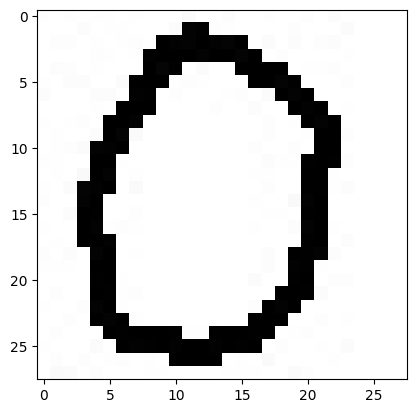

In [80]:
import matplotlib.image as mpimg
img = mpimg.imread('0.jpg')
imgplot = plt.imshow(img)

In [81]:
img = torch.tensor(img)
img.shape

torch.Size([28, 28, 3])

In [82]:
transform = transforms.Compose([transforms.ToTensor()])

test_imgs = []

for i in range(10):

  img = cv2.imread(f'{i}.jpg')
  # Here the image gets normalized
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # transform to a tensor
  img = transform(img)
  # Invert the image, since originally the digits are written in black (0 value)
  img = invert(img)
  # Convert to grayscale
  img = rgb_to_grayscale(img)

  test_imgs.append(img)

In [83]:
type(test_imgs[0])

torch.Tensor

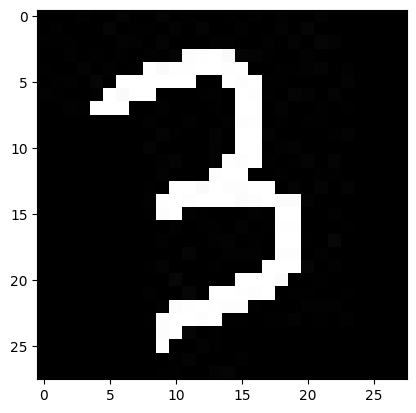

In [84]:
plt.imshow(test_imgs[3].squeeze(), cmap = 'gray')

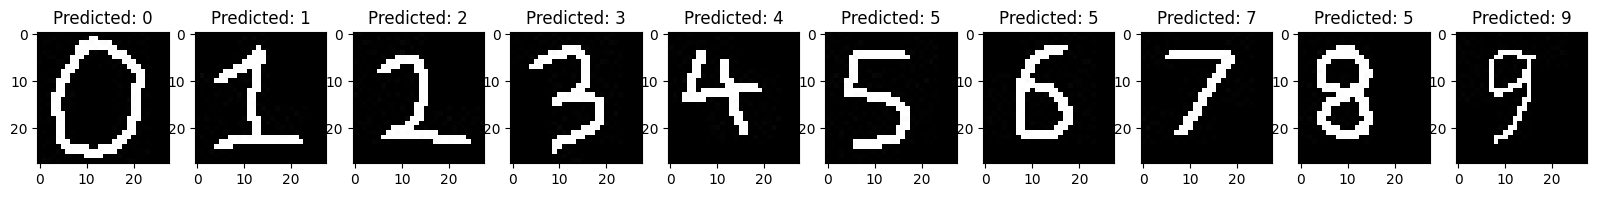

In [85]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Create a figure with 10 subplots

for i in range(10):
    image = test_imgs[i].squeeze().numpy()  # Convert the tensor to a NumPy array for plotting
    output = torch.argmax(bidirectional_net(test_imgs[i]), dim=1, keepdim=True).item()

    axes[i].imshow(image, cmap='gray')  # Display the image in the subplot
    axes[i].set_title(f"Predicted: {output}")  # Set the title with the predicted value

plt.show()

# 2. Adding 2 binary strings

We will first define the model

In [86]:
class BitAdderLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(BitAdderLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out,(h_n,c_n) = self.lstm(torch.flip(x,[0]))
    out = self.fc(out)
    return torch.sigmoid(out)
    pass
pass

We will now define a function to calculate the bit accuracy

In [87]:
def bit_acc(bit_adder, train_set):
  count = 0
  n = len(train_set)
  for data in train_set:
    input = data[0]
    label = data[1]
    output = bit_adder(input)
    output = torch.reshape(torch.tensor([1 if x>0.5 else 0 for x in bit_adder(input)]), output.shape)
    for i in range(output.shape[0]):
      if(label[i]==output[i]):
        count+=1

  return (count/(n*output.shape[0]))*100

We will now look at 3 length of binary strings - 10,5,3. Let us start with 5 as we intend to find the best performing model, and strings of length 3 will give us very high accuracies, making it hard to distinguish between a better model

## Case 1a : L = 5, Hidden Dimensions = 5, Loss = MSE

In [88]:
L = 5
hidden_size = 5
input_size = 2
num_classes = 1

In [89]:
bit_adder  = BitAdderLSTM(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(bit_adder.parameters(), lr = 0.01)

We will now create the training and validation datasets

In [90]:
train_set = []

n = 5000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  train_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/3354823864.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


In [91]:
val_set = []

n = 1000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  val_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/1792490742.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


Training the model

In [92]:
epochs = 15
train_loss = []
iter_list_bit = []
val_loss=[]
epoch_list=[]
iter = 0

for epoch in range(epochs):
  curr_loss=0
  for i in train_set:
    t = i[0]
    label = i[1]
    output = bit_adder(t)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curr_loss+=loss.item()
    iter+=1
    if(iter%750==0):
      train_loss.append(loss.item())
      iter_list_bit.append(iter)

  print("Epochs = ",(epoch+1))
  print("Loss = ",(curr_loss/len(train_set)))
  print("Bit accuracy on Training Data = ",(bit_acc(bit_adder, train_set)))
  print("Bit accuracy on Validation Data = ",(bit_acc(bit_adder, val_set)))

  bit_adder.eval()
  v_loss = 0
  with torch.no_grad():
    for j in val_set:
      val_t = j[0]
      val_label = j[1]
      output = bit_adder(val_t)

      loss = criterion(output, val_label)
      v_loss +=loss.item()

    val_loss.append(v_loss/len(val_set))
    epoch_list.append(epoch+1)

Epochs =  1
Loss =  0.20971233269274234
Bit accuracy on Training Data =  60.156666666666666
Bit accuracy on Validation Data =  59.699999999999996
Epochs =  2
Loss =  0.20730182620584964
Bit accuracy on Training Data =  60.370000000000005
Bit accuracy on Validation Data =  60.050000000000004
Epochs =  3
Loss =  0.20702968824505805
Bit accuracy on Training Data =  60.61666666666666
Bit accuracy on Validation Data =  60.266666666666666
Epochs =  4
Loss =  0.20181484975516797
Bit accuracy on Training Data =  63.07333333333334
Bit accuracy on Validation Data =  62.78333333333334
Epochs =  5
Loss =  0.1980178389303386
Bit accuracy on Training Data =  63.303333333333335
Bit accuracy on Validation Data =  62.68333333333334
Epochs =  6
Loss =  0.19312627361044288
Bit accuracy on Training Data =  64.32333333333334
Bit accuracy on Validation Data =  63.63333333333333
Epochs =  7
Loss =  0.1822259769052267
Bit accuracy on Training Data =  71.35000000000001
Bit accuracy on Validation Data =  70.75


Now visualising the training loss and validation loss

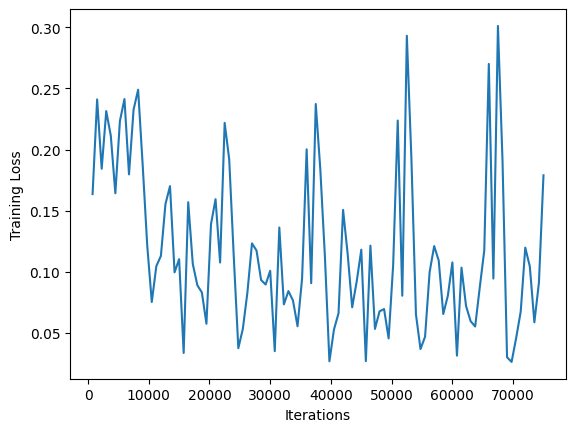

In [ ]:
plt.plot(iter_list_bit, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

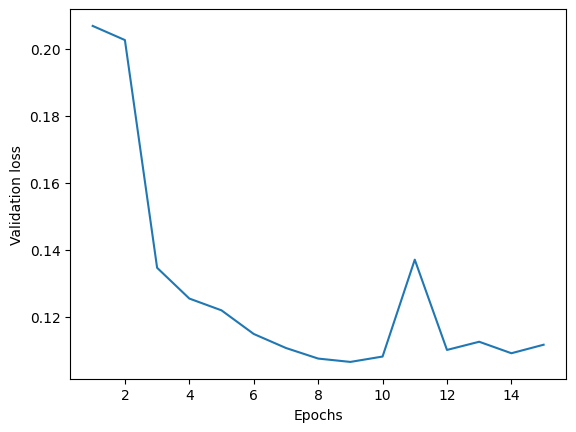

In [ ]:
plt.plot(epoch_list, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

## Case 1b : L = 5, Hidden Dimensions = 10, Loss = MSE

In [ ]:
L = 5
hidden_size = 10
input_size = 2
num_classes = 1

In [ ]:
bit_adder  = BitAdderLSTM(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(bit_adder.parameters(), lr = 0.01)

In [ ]:
epochs = 15
train_loss = []
iter_list_bit = []
val_loss=[]
epoch_list=[]
iter = 0

for epoch in range(epochs):
  curr_loss=0
  for i in train_set:
    t = i[0]
    label = i[1]
    output = bit_adder(t)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curr_loss+=loss.item()
    iter+=1
    if(iter%750==0):
      train_loss.append(loss.item())
      iter_list_bit.append(iter)

  print("Epochs = ",(epoch+1))
  print("Loss = ",(curr_loss/len(train_set)))
  print("Bit accuracy on Training Data = ",(bit_acc(bit_adder, train_set)))
  print("Bit accuracy on Validation Data = ",(bit_acc(bit_adder, val_set)))

  bit_adder.eval()
  v_loss = 0
  with torch.no_grad():
    for j in val_set:
      val_t = j[0]
      val_label = j[1]
      output = bit_adder(val_t)

      loss = criterion(output, val_label)
      v_loss +=loss.item()

    val_loss.append(v_loss/len(val_set))
    epoch_list.append(epoch+1)

Epochs =  1
Loss =  0.2093748391121626
Bit accuracy on Training Data =  60.263333333333335
Bit accuracy on Validation Data =  60.050000000000004
Epochs =  2
Loss =  0.13996716958852484
Bit accuracy on Training Data =  85.14666666666668
Bit accuracy on Validation Data =  85.2
Epochs =  3
Loss =  0.09159669604692608
Bit accuracy on Training Data =  85.83666666666666
Bit accuracy on Validation Data =  85.36666666666667
Epochs =  4
Loss =  0.08833521675830706
Bit accuracy on Training Data =  83.49666666666667
Bit accuracy on Validation Data =  83.0
Epochs =  5
Loss =  0.08636599530968815
Bit accuracy on Training Data =  85.59333333333333
Bit accuracy on Validation Data =  85.03333333333333
Epochs =  6
Loss =  0.09769461893886328
Bit accuracy on Training Data =  82.22
Bit accuracy on Validation Data =  81.45
Epochs =  7
Loss =  0.10890740901697427
Bit accuracy on Training Data =  83.72
Bit accuracy on Validation Data =  83.2
Epochs =  8
Loss =  0.08938661627396942
Bit accuracy on Training D

Visualising the training and validation loss

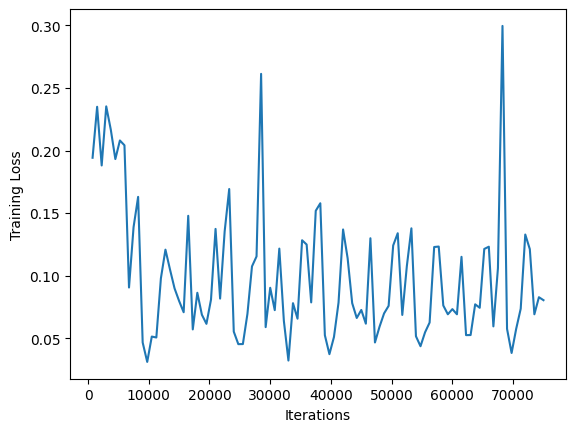

In [ ]:
plt.plot(iter_list_bit, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

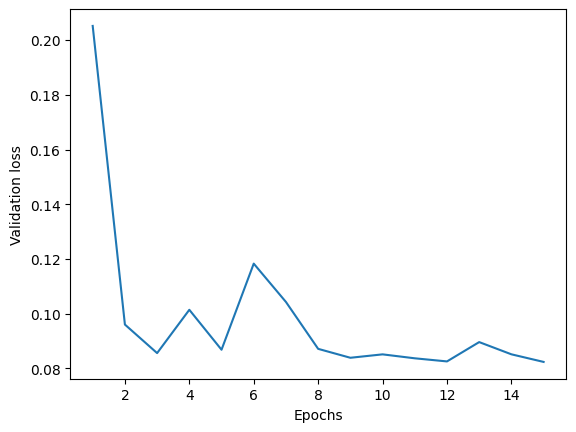

In [ ]:
plt.plot(epoch_list, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

We can therefor conclude that hidden dimension of 10 is better as it clearly gives us more accurate predictions

## Case 1c : L = 5, Hidden Dimensions = 10, Loss = BCE

In [ ]:
bit_adder_bce  = BitAdderLSTM(input_size, hidden_size, num_classes)
criterion = nn.BCELoss()
optimizer = optim.Adam(bit_adder_bce.parameters(), lr = 0.01)

In [ ]:
epochs = 15
train_loss = []
iter_list_bit = []
val_loss=[]
epoch_list=[]
iter = 0

for epoch in range(epochs):
  curr_loss=0
  for i in train_set:
    t = i[0]
    label = i[1]
    output = bit_adder_bce(t)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curr_loss+=loss.item()
    iter+=1
    if(iter%750==0):
      train_loss.append(loss.item())
      iter_list_bit.append(iter)

  print("Epochs = ",(epoch+1))
  print("Loss = ",(curr_loss/len(train_set)))
  print("Bit accuracy on Training Data = ",(bit_acc(bit_adder_bce, train_set)))
  print("Bit accuracy on Validation Data = ",(bit_acc(bit_adder_bce, val_set)))

  bit_adder_bce.eval()
  v_loss = 0
  with torch.no_grad():
    for j in val_set:
      val_t = j[0]
      val_label = j[1]
      output = bit_adder_bce(val_t)

      loss = criterion(output, val_label)
      v_loss +=loss.item()

    val_loss.append(v_loss/len(val_set))
    epoch_list.append(epoch+1)

Epochs =  1
Loss =  0.576942695659399
Bit accuracy on Training Data =  72.57666666666667
Bit accuracy on Validation Data =  72.21666666666667
Epochs =  2
Loss =  0.4606806327342987
Bit accuracy on Training Data =  79.14999999999999
Bit accuracy on Validation Data =  78.88333333333334
Epochs =  3
Loss =  0.38584162459224464
Bit accuracy on Training Data =  81.82000000000001
Bit accuracy on Validation Data =  82.18333333333334
Epochs =  4
Loss =  0.2945726648181677
Bit accuracy on Training Data =  83.82
Bit accuracy on Validation Data =  84.13333333333334
Epochs =  5
Loss =  0.27286986744999886
Bit accuracy on Training Data =  83.99
Bit accuracy on Validation Data =  84.58333333333333
Epochs =  6
Loss =  0.2626480425953865
Bit accuracy on Training Data =  84.66
Bit accuracy on Validation Data =  84.48333333333333
Epochs =  7
Loss =  0.2591472256064415
Bit accuracy on Training Data =  84.84
Bit accuracy on Validation Data =  84.88333333333333
Epochs =  8
Loss =  0.2583745244383812
Bit acc

Now we will visualise the training and validation loss

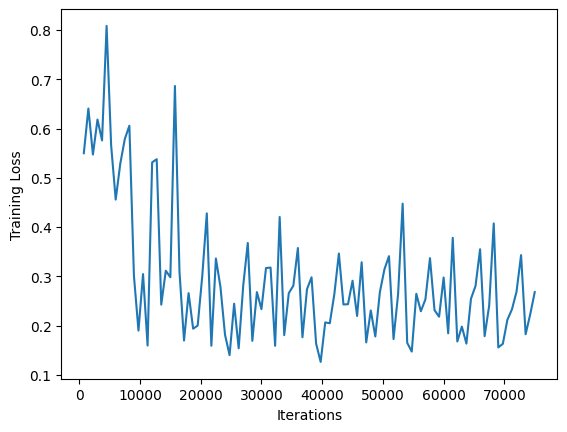

In [ ]:
plt.plot(iter_list_bit, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

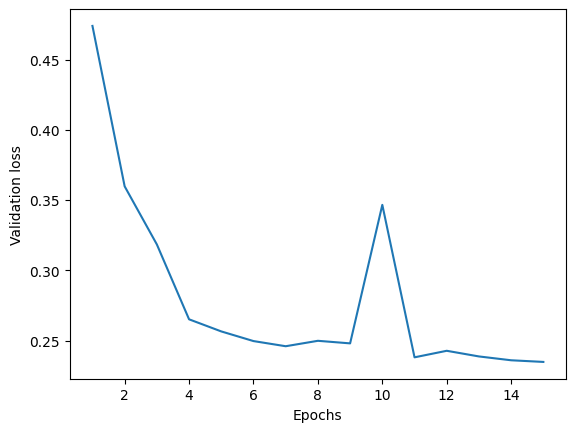

In [ ]:
plt.plot(epoch_list, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

We can conclude that MSE is better than BCE as MSE gave us a higher accuracy

## Now we will create lists of 100 values of various bit sizes

In [ ]:
final_list = []
for L in range(1,21):
  n = 100
  sub_list = []
  for i in range(n):
    a = random.randint(2**(L-1), 2**L -1)
    bin_a = bin(a)
    b = random.randint(2**(L-1), 2**L -1)
    bin_b = bin(b)
    sum = a + b
    bin_sum = bin(sum)
    temp = torch.zeros([L+1,2])
    for j in range(1,L+1):
      temp[j][0] = float(bin_a[j+1])
      temp[j][1] = float(bin_b[j+1])
    temp = torch.tensor(temp,requires_grad = True)
    label = torch.empty([len(bin_sum)-2,1])
    for k in range(2,len(bin_sum)):
      label[k-2]= float(bin_sum[k])

    sub_list.append([temp,label])
  final_list.append(sub_list)

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/3601042506.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


In [ ]:
length = 1
length_list = []
acc_list = []
for sub_list in final_list:
  acc = bit_acc(bit_adder_bce, sub_list)
  print("Length =", length, "  Accuracy = ", acc)
  length_list.append(length)
  acc_list.append(acc)
  length+=1

Length = 1   Accuracy =  100.0
Length = 2   Accuracy =  66.66666666666666
Length = 3   Accuracy =  73.25
Length = 4   Accuracy =  68.2
Length = 5   Accuracy =  85.66666666666667
Length = 6   Accuracy =  65.71428571428571
Length = 7   Accuracy =  63.24999999999999
Length = 8   Accuracy =  62.11111111111111
Length = 9   Accuracy =  58.699999999999996
Length = 10   Accuracy =  57.63636363636364
Length = 11   Accuracy =  57.91666666666667
Length = 12   Accuracy =  56.92307692307692
Length = 13   Accuracy =  56.57142857142857
Length = 14   Accuracy =  55.53333333333333
Length = 15   Accuracy =  55.75
Length = 16   Accuracy =  52.764705882352935
Length = 17   Accuracy =  54.50000000000001
Length = 18   Accuracy =  52.78947368421053
Length = 19   Accuracy =  53.25
Length = 20   Accuracy =  54.23809523809524


Text(0, 0.5, 'Average Accuracy')

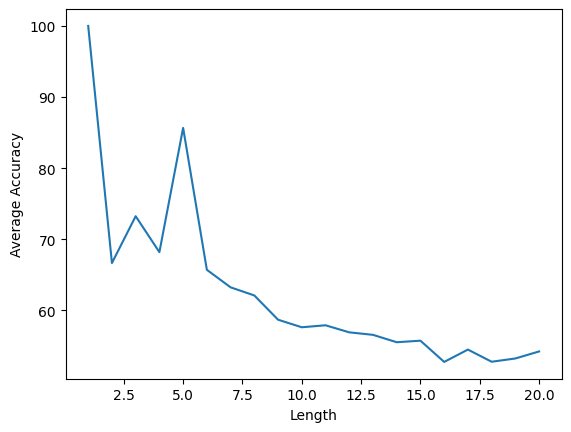

In [ ]:
plt.plot(length_list, acc_list)
plt.xlabel("Length")
plt.ylabel("Average Accuracy")

We clearly notice that as the bit size of the number gets larger, the accuracy drops

## Case 2 : L = 3

In [ ]:
L = 3
hidden_size = 3
input_size = 2
num_classes = 1

In [ ]:
bit_adder_bce  = BitAdderLSTM(input_size, hidden_size, num_classes)
criterion = nn.BCELoss()
optimizer = optim.Adam(bit_adder_bce.parameters(), lr = 0.01)

Creating the training and validation sets

In [ ]:
train_set = []

n = 5000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  train_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/3354823864.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


In [ ]:
val_set = []

n = 1000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  val_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/1792490742.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


Now training the model

In [ ]:
epochs = 15
train_loss = []
iter_list_bit = []
val_loss=[]
epoch_list=[]
iter = 0

for epoch in range(epochs):
  curr_loss=0
  for i in train_set:
    t = i[0]
    label = i[1]
    output = bit_adder_bce(t)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curr_loss+=loss.item()
    iter+=1
    if(iter%750==0):
      train_loss.append(loss.item())
      iter_list_bit.append(iter)

  print("Epochs = ",(epoch+1))
  print("Loss = ",(curr_loss/len(train_set)))
  print("Bit accuracy on Training Data = ",(bit_acc(bit_adder_bce, train_set)))
  print("Bit accuracy on Validation Data = ",(bit_acc(bit_adder_bce, val_set)))

  bit_adder.eval()
  v_loss = 0
  with torch.no_grad():
    for j in val_set:
      val_t = j[0]
      val_label = j[1]
      output = bit_adder_bce(val_t)

      loss = criterion(output, val_label)
      v_loss +=loss.item()

    val_loss.append(v_loss/len(val_set))
    epoch_list.append(epoch+1)

Epochs =  1
Loss =  0.2371678003068907
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  2
Loss =  0.015104526909099459
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  3
Loss =  0.023128499023944777
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  4
Loss =  0.0007311916442798065
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  5
Loss =  7.363624556696777e-05
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  6
Loss =  0.028962393043655662
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  7
Loss =  6.612643009496395e-05
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  8
Loss =  1.387756748391098e-05
Bit accuracy on Training Data =  100.0
Bit accuracy on Validation Data =  100.0
Epochs =  9
Loss =  3.78777529

Visualising the training and validation loss

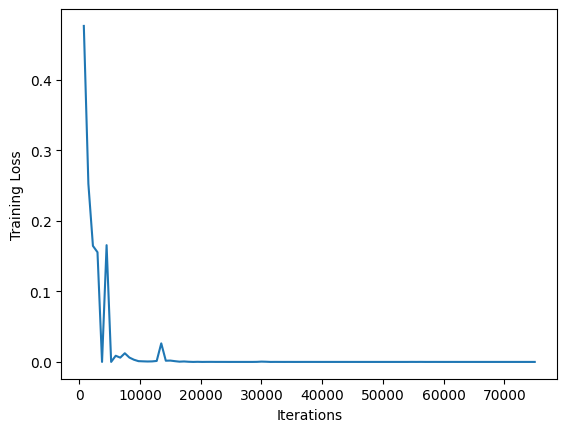

In [ ]:
plt.plot(iter_list_bit, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

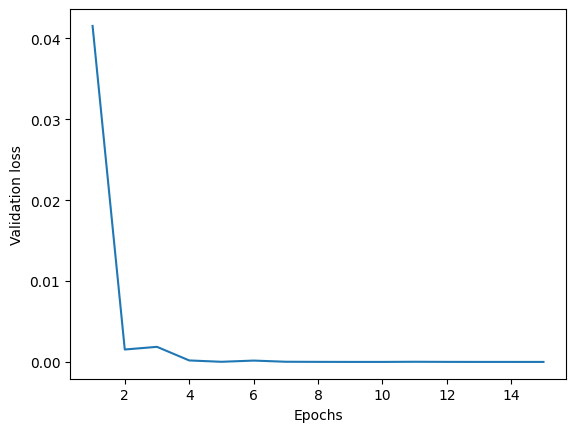

In [ ]:
plt.plot(epoch_list, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

Plotting the accuracies of different length values

In [ ]:
length = 1
length_list = []
acc_list = []
for sub_list in final_list:
  acc = bit_acc(bit_adder_bce, sub_list)
  print("Length =", length, "  Accuracy = ", acc)
  length_list.append(length)
  acc_list.append(acc)
  length+=1

Length = 1   Accuracy =  100.0
Length = 2   Accuracy =  57.666666666666664
Length = 3   Accuracy =  100.0
Length = 4   Accuracy =  66.4
Length = 5   Accuracy =  64.83333333333333
Length = 6   Accuracy =  57.99999999999999
Length = 7   Accuracy =  59.25
Length = 8   Accuracy =  59.22222222222222
Length = 9   Accuracy =  54.50000000000001
Length = 10   Accuracy =  56.36363636363636
Length = 11   Accuracy =  54.25
Length = 12   Accuracy =  54.230769230769226
Length = 13   Accuracy =  53.78571428571428
Length = 14   Accuracy =  54.2
Length = 15   Accuracy =  53.5625
Length = 16   Accuracy =  54.294117647058826
Length = 17   Accuracy =  54.27777777777778
Length = 18   Accuracy =  54.10526315789473
Length = 19   Accuracy =  53.15
Length = 20   Accuracy =  51.523809523809526


Text(0, 0.5, 'Average Accuracy')

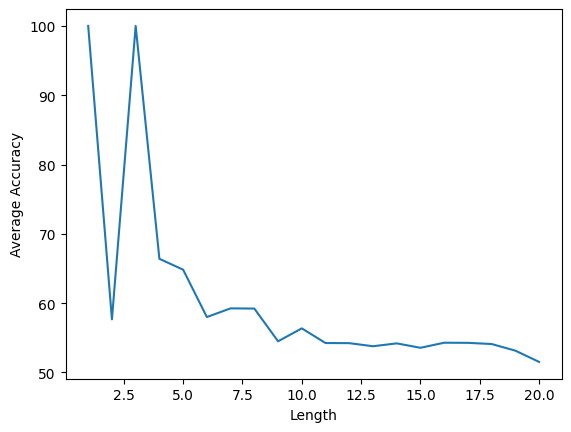

In [ ]:
plt.plot(length_list, acc_list)
plt.xlabel("Length")
plt.ylabel("Average Accuracy")

## Case 3: L = 10

In [ ]:
L = 10
hidden_size = 10
input_size = 2
num_classes = 1

In [ ]:
bit_adder_bce  = BitAdderLSTM(input_size, hidden_size, num_classes)
criterion = nn.BCELoss()
optimizer = optim.Adam(bit_adder_bce.parameters(), lr = 0.01)

Creating training and validation sets

In [ ]:
train_set = []

n = 5000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  train_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/3354823864.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


In [ ]:
val_set = []

n = 1000
for i in range(n):
  a = random.randint(2**(L-1), 2**L -1)
  bin_a = bin(a)
  b = random.randint(2**(L-1), 2**L -1)
  bin_b = bin(b)
  sum = a + b
  bin_sum = bin(sum)
  temp = torch.zeros([L+1,2])
  for j in range(1,L+1):
    temp[j][0] = float(bin_a[j+1])
    temp[j][1] = float(bin_b[j+1])
  temp = torch.tensor(temp,requires_grad = True)
  label = torch.empty([len(bin_sum)-2,1])
  for k in range(2,len(bin_sum)):
    label[k-2]= float(bin_sum[k])
  val_set.append([temp,label])

/var/folders/13/twz8kwfs1qv_4w_c6dzc_57m0000gn/T/ipykernel_22954/1792490742.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.tensor(temp,requires_grad = True)


Training the model

In [ ]:
epochs = 15
train_loss = []
iter_list_bit = []
val_loss=[]
epoch_list=[]
iter = 0

for epoch in range(epochs):
  curr_loss=0
  for i in train_set:
    t = i[0]
    label = i[1]
    output = bit_adder_bce(t)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    curr_loss+=loss.item()
    iter+=1
    if(iter%750==0):
      train_loss.append(loss.item())
      iter_list_bit.append(iter)

  print("Epochs = ",(epoch+1))
  print("Loss = ",(curr_loss/len(train_set)))
  print("Bit accuracy on Training Data = ",(bit_acc(bit_adder_bce, train_set)))
  print("Bit accuracy on Validation Data = ",(bit_acc(bit_adder_bce, val_set)))

  bit_adder.eval()
  v_loss = 0
  with torch.no_grad():
    for j in val_set:
      val_t = j[0]
      val_label = j[1]
      output = bit_adder_bce(val_t)

      loss = criterion(output, val_label)
      v_loss +=loss.item()

    val_loss.append(v_loss/len(val_set))
    epoch_list.append(epoch+1)

Epochs =  1
Loss =  0.6351559948325157
Bit accuracy on Training Data =  54.78363636363637
Bit accuracy on Validation Data =  54.627272727272725
Epochs =  2
Loss =  0.6312532629847527
Bit accuracy on Training Data =  54.60727272727273
Bit accuracy on Validation Data =  54.21818181818182
Epochs =  3
Loss =  0.6306125155806541
Bit accuracy on Training Data =  55.59090909090909
Bit accuracy on Validation Data =  55.50909090909091


KeyboardInterrupt: 

Visulaising the training and validation loss

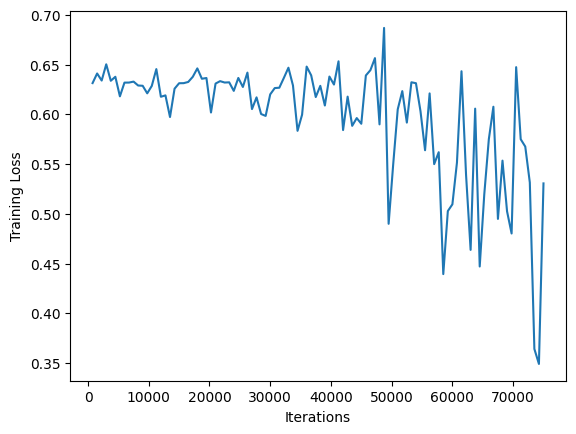

In [ ]:
plt.plot(iter_list_bit, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

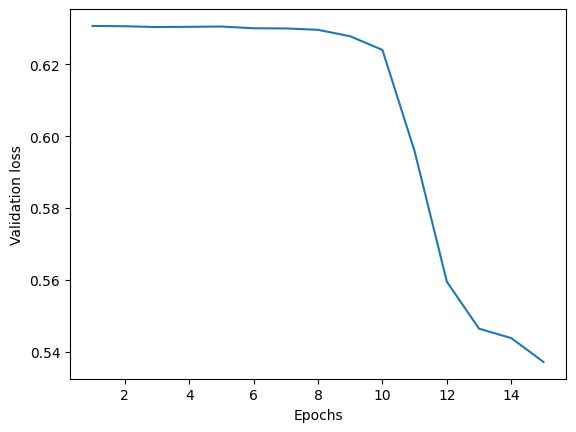

In [ ]:
plt.plot(epoch_list, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.show()

Plotting the accuracies for various bit lengths

In [ ]:
length = 1
length_list = []
acc_list = []
for sub_list in final_list:
  acc = bit_acc(bit_adder_bce, sub_list)
  print("Length =", length, "  Accuracy = ", acc)
  length_list.append(length)
  acc_list.append(acc)
  length+=1

Length = 1   Accuracy =  50.0
Length = 2   Accuracy =  57.99999999999999
Length = 3   Accuracy =  59.5
Length = 4   Accuracy =  61.4
Length = 5   Accuracy =  58.333333333333336
Length = 6   Accuracy =  63.142857142857146
Length = 7   Accuracy =  60.5
Length = 8   Accuracy =  71.0
Length = 9   Accuracy =  62.0
Length = 10   Accuracy =  66.9090909090909
Length = 11   Accuracy =  63.66666666666667
Length = 12   Accuracy =  62.23076923076923
Length = 13   Accuracy =  63.142857142857146
Length = 14   Accuracy =  61.86666666666667
Length = 15   Accuracy =  60.3125
Length = 16   Accuracy =  59.529411764705884
Length = 17   Accuracy =  58.38888888888889
Length = 18   Accuracy =  57.631578947368425
Length = 19   Accuracy =  58.199999999999996
Length = 20   Accuracy =  58.333333333333336


Text(0, 0.5, 'Average Accuracy')

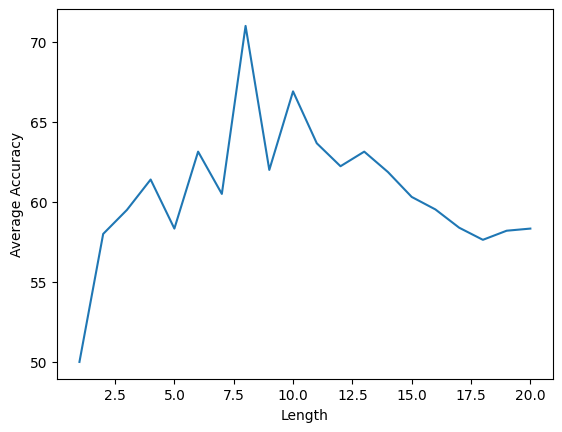

In [ ]:
plt.plot(length_list, acc_list)
plt.xlabel("Length")
plt.ylabel("Average Accuracy")

# Resources
1. https://medium.com/@nutanbhogendrasharma/pytorch-recurrent-neural-networks-with-mnist-dataset-2195033b540f
2. https://medium.com/@nathaliejeans/how-i-classified-images-with-recurrent-neural-networks-28eb4b57fc79
3. https://github.com/M-Kasem/pytorch-bidirectional-lstm/blob/master/main.py
4. https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/